# Content
DATABASE DESIGN AND IMPLEMENTATION

DATA POPULATION

DATA QUERY

INTEGRATION WITH PYSPARK

PYTHON QUERY
https://github.com/AXBOUF/python_visulization/blob/main/MunalBaraili_900006725_Bigdata_Final.pdf

# Database Design and Implementation

I separated high-level workout metadata from granular time-series “trackpoint” data to improve lookup efficiency, enable indexing on workout_id.

In [ ]:
from pymongo import MongoClient
from dotenv import load_dotenv
import os
# uri stored in a .env
# Load .env
load_dotenv()

# Get connection string
uri = os.getenv("MONGO_URI")

# Connect
client = MongoClient(uri)

db = client["Fitrec_db"]  # Fitrec_db is our database name

# List collections
print("Collections inside FitRec DB:")
print(db.list_collection_names())
# intitially we dont have any collections.

Collections inside FitRec DB:
[]


In [ ]:
from itertools import islice

path = "./endomondoHr_proper.json" # file downloaded from kaggle



In [ ]:
import ast, random
# taking a random sample subset from the while dataset, a few thousand rows or 1-2% of the total data
sample = []
keep_prob = 0.01

with open(path) as f:
    for line in f:
        if random.random() < keep_prob:
            w = ast.literal_eval(line)
            sample.append(w)

print(len(sample))


1710


We have 1710 total count

In [ ]:
import ast

# Look at the first workout
first = sample[0]

print("Top-level keys:", first.keys())


Top-level keys: dict_keys(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate', 'gender', 'url', 'userId', 'timestamp'])


We have longitude , altitude , latitude, sport , id, heart_rate, gender, url, userId, timestamp

In [ ]:
for k, v in first.items():
    print(k, "→", type(v))


longitude → <class 'list'>
altitude → <class 'list'>
latitude → <class 'list'>
sport → <class 'str'>
id → <class 'int'>
heart_rate → <class 'list'>
gender → <class 'str'>
url → <class 'str'>
userId → <class 'int'>
timestamp → <class 'list'>


variables with their datatypes

In [ ]:
L = len(first["timestamp"])
print("Length of arrays:", L)

for k in ["latitude","longitude","altitude","heart_rate"]:
    print(k, len(first[k]))


Length of arrays: 500
latitude 500
longitude 500
altitude 500
heart_rate 500


In [ ]:
from collections import Counter
Counter([w["sport"] for w in sample]).most_common(10)


[('bike', 751),
 ('run', 685),
 ('mountain bike', 118),
 ('bike (transport)', 85),
 ('walk', 16),
 ('indoor cycling', 15),
 ('orienteering', 10),
 ('cross-country skiing', 7),
 ('skate', 6),
 ('hiking', 3)]

In [ ]:
len({w["userId"] for w in sample})


638

In [ ]:
w = sample[0]
for k in ["longitude","latitude","altitude","heart_rate","timestamp"]:
    print(k, len(w[k]))


longitude 500
latitude 500
altitude 500
heart_rate 500
timestamp 500


In [ ]:
print("Total workouts:", len(sample))
unique_users = {w['userId'] for w in sample}
print("Unique users:", len(unique_users))


Total workouts: 1710
Unique users: 638


In [ ]:
uid = sample[0]['userId']
user_workouts = [w for w in sample if w['userId'] == uid]

print("User:", uid)
print("Workouts for this user:", len(user_workouts))


User: 10921915
Workouts for this user: 1


In [ ]:
lengths = [len(w["timestamp"]) for w in sample]
print("Min:", min(lengths))
print("Max:", max(lengths))
print("Average:", sum(lengths)/len(lengths))


Min: 500
Max: 500
Average: 500.0


In [ ]:
uid = sample[0]["userId"]
for w in sample:
    if w["userId"] == uid:
        print(len(w["timestamp"]))


500


In [ ]:
from collections import Counter

genders = [w['gender'] for w in sample if 'gender' in w]
print(Counter(genders))


Counter({'male': 1603, 'female': 93, 'unknown': 14})


In [ ]:
user_gender = {}

for w in sample:
    user_gender[w['userId']] = w['gender']

from collections import Counter
Counter(user_gender.values())


Counter({'male': 586, 'female': 47, 'unknown': 5})

Findings of intial exploration of data
Total workout= 1710 ~ sample subset of the big dataset
Unique Users: 638
Uniform Time-series length
Sports Distribution = Bike, Run, Walking, Mountain Bike etc

We have 1% sample which is high-quality,representative, and DB-ready

# Data Population
Connected via PyMongo

Created collections

Inserted workouts (1710 docs)

Inserted trackpoints (774,000 docs)

Created index: trackpoints(workout_id, seq)

In [ ]:
from pymongo import MongoClient

# Load .env
load_dotenv()

# Get connection string
uri = os.getenv("MONGO_URI")

# Connect
client = MongoClient(uri)

# List all databases
print("Databases:", client.list_database_names())


Databases: ['admin', 'local']


In [ ]:
db = client["fitrec_db"]
print("Collections inside fitrec_db:", db.list_collection_names())


Collections inside fitrec_db: []


## Creating collections workouts --> trackpoints

In [ ]:
db.create_collection("workouts")
db.create_collection("trackpoints")


Collection(Database(MongoClient(host=['cluster0-shard-00-01.8gyvc.mongodb.net:27017', 'cluster0-shard-00-00.8gyvc.mongodb.net:27017', 'cluster0-shard-00-02.8gyvc.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, appname='Cluster0', authsource='admin', replicaset='atlas-lzok0y-shard-0', ssl=True), 'fitrec_db'), 'trackpoints')

In [ ]:
print("Collections inside fitrec_db:", db.list_collection_names())

Collections inside fitrec_db: ['trackpoints', 'workouts']


#### Testing if write permission exists

In [ ]:
workouts_col = db["workouts"]

test_doc = {
    "workout_id": 111,
    "user_id": 222,
    "gender": "test",
    "sport": "test_sport",
    "num_points": 500
}

result = workouts_col.insert_one(test_doc)
print("Inserted ID:", result.inserted_id)


Inserted ID: 692535ef397f0125f5f6f5d3


In [ ]:
print(workouts_col.count_documents({}))
print(workouts_col.find_one({}))


1
{'_id': ObjectId('692535ef397f0125f5f6f5d3'), 'workout_id': 111, 'user_id': 222, 'gender': 'test', 'sport': 'test_sport', 'num_points': 500}


#### roll back delete the test document

In [ ]:
workouts_col.delete_one({"workout_id": 111})


In [ ]:
print("Remaining docs:", workouts_col.count_documents({}))


Remaining docs: 0


In [ ]:
for w in sample:
    workouts_col.insert_one({
        "workout_id": w["id"],
        "user_id": w["userId"],
        "gender": w["gender"],
        "sport": w["sport"],
        "url": w.get("url", None),
        "num_points": len(w["timestamp"])
    })


In [ ]:
workouts_col.count_documents({})


1710

In [ ]:
workouts_col.find_one()


{'_id': ObjectId('69253678397f0125f5f6f5d4'),
 'workout_id': 381331596,
 'user_id': 10921915,
 'gender': 'male',
 'sport': 'bike (transport)',
 'url': 'https://www.endomondo.com/users/10921915/workouts/381331596',
 'num_points': 500}

Random user_id document

#### Trackpoint insertion (Batch Method)

In [ ]:
from pymongo import InsertOne
trackpoints_col = db["trackpoints"]

batch_size = 2000   # tune if needed
batch = []

for w in sample:
    wid = w["id"]
    for i in range(len(w["timestamp"])):
        batch.append(InsertOne({
            "workout_id": wid,
            "seq": i,
            "timestamp": w["timestamp"][i],
            "lat": w["latitude"][i],
            "lon": w["longitude"][i],
            "alt": w["altitude"][i],
            "hr": w["heart_rate"][i]
        }))

        if len(batch) == batch_size:
            trackpoints_col.bulk_write(batch)
            batch = []

# flush remaining
if batch:
    trackpoints_col.bulk_write(batch)

print("Trackpoints inserted:", trackpoints_col.count_documents({}))


Trackpoints inserted: 855000


In [ ]:
trackpoints_col.count_documents({})


855000

## Indexing

In [ ]:
# Index for fast workout lookups
db.workouts.create_index("workout_id")

# Index for user-level queries
db.workouts.create_index("user_id")

# Compound index for trackpoints
db.trackpoints.create_index([("workout_id", 1), ("seq", 1)])


'workout_id_1_seq_1'

In [ ]:
list(db.workouts.find({"user_id": 10921915}).limit(5))


[{'_id': ObjectId('69253678397f0125f5f6f5d4'),
  'workout_id': 381331596,
  'user_id': 10921915,
  'gender': 'male',
  'sport': 'bike (transport)',
  'url': 'https://www.endomondo.com/users/10921915/workouts/381331596',
  'num_points': 500}]

In [ ]:
example = db.workouts.find_one({})
wid = example["workout_id"]
list(db.workouts.find({"workout_id": wid}))


[{'_id': ObjectId('69253678397f0125f5f6f5d4'),
  'workout_id': 381331596,
  'user_id': 10921915,
  'gender': 'male',
  'sport': 'bike (transport)',
  'url': 'https://www.endomondo.com/users/10921915/workouts/381331596',
  'num_points': 500}]

# Data Query Demonstration

In [ ]:
db.workouts.count_documents({}) # returns documents counts in workout collection


1710

In [ ]:
db.workouts.distinct("sport") # seeing what sports are in our dataset


['bike',
 'bike (transport)',
 'circuit training',
 'core stability training',
 'cross-country skiing',
 'downhill skiing',
 'fitness walking',
 'hiking',
 'indoor cycling',
 'mountain bike',
 'orienteering',
 'pilates',
 'rowing',
 'run',
 'skate',
 'soccer',
 'treadmill running',
 'walk']

we have bike, run , skate, rowing, soccer, walk and so on.

In [ ]:
result = list(db.workouts.aggregate([
    {"$group": {"_id": "$sport", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]))


for row in result:
    print(f"{row['_id']}: {row['count']}")


bike: 751
run: 685
mountain bike: 118
bike (transport): 85
walk: 16
indoor cycling: 15
orienteering: 10
cross-country skiing: 7
skate: 6
core stability training: 3
hiking: 3
treadmill running: 3
circuit training: 3
soccer: 1
fitness walking: 1
pilates: 1
downhill skiing: 1
rowing: 1


count of those distinct sport in our workout

Top 10 most active users (who worked out the most)

In [ ]:
result = list(db.workouts.aggregate([
    {"$group": {"_id": "$user_id", "total_workouts": {"$sum": 1}}},
    {"$sort": {"total_workouts": -1}},
    {"$limit": 10}
]))

for row in result:
    print(f"User {row['_id']} → {row['total_workouts']} workouts")


User 2734298 → 18 workouts
User 4997910 → 14 workouts
User 1063624 → 13 workouts
User 14066832 → 12 workouts
User 9051351 → 12 workouts
User 4446822 → 11 workouts
User 1520156 → 11 workouts
User 7516129 → 10 workouts
User 171814 → 10 workouts
User 510054 → 10 workouts


we would have been able to map the users if given names but user_id is not bad too

all workouts done by female users

In [ ]:
result = list(db.workouts.find({"gender": "female"}).limit(10))

for row in result:
    print(row)


{'_id': ObjectId('69253678397f0125f5f6f5f8'), 'workout_id': 199475240, 'user_id': 5325166, 'gender': 'female', 'sport': 'bike', 'url': 'https://www.endomondo.com/users/5325166/workouts/199475240', 'num_points': 500}
{'_id': ObjectId('6925367a397f0125f5f6f646'), 'workout_id': 367328264, 'user_id': 3288898, 'gender': 'female', 'sport': 'walk', 'url': 'https://www.endomondo.com/users/3288898/workouts/367328264', 'num_points': 500}
{'_id': ObjectId('6925367a397f0125f5f6f647'), 'workout_id': 241918685, 'user_id': 3288898, 'gender': 'female', 'sport': 'walk', 'url': 'https://www.endomondo.com/users/3288898/workouts/241918685', 'num_points': 500}
{'_id': ObjectId('6925367b397f0125f5f6f66d'), 'workout_id': 323537834, 'user_id': 4203888, 'gender': 'female', 'sport': 'bike', 'url': 'https://www.endomondo.com/users/4203888/workouts/323537834', 'num_points': 500}
{'_id': ObjectId('6925367b397f0125f5f6f689'), 'workout_id': 555116053, 'user_id': 775277, 'gender': 'female', 'sport': 'run', 'url': 'ht

In [ ]:
result = list(db.workouts.find({"gender": "female"}, {"sport": 1, "user_id": 1, "_id": 0}).limit(10))

for row in result:
    print(row)


{'user_id': 5325166, 'sport': 'bike'}
{'user_id': 3288898, 'sport': 'walk'}
{'user_id': 3288898, 'sport': 'walk'}
{'user_id': 4203888, 'sport': 'bike'}
{'user_id': 775277, 'sport': 'run'}
{'user_id': 775277, 'sport': 'run'}
{'user_id': 775277, 'sport': 'run'}
{'user_id': 5407179, 'sport': 'skate'}
{'user_id': 11258520, 'sport': 'walk'}
{'user_id': 6670535, 'sport': 'run'}


only selecting sports to see in respect to what sports they play

Query 4 we will insert a summary into a new collection

In [ ]:
sport_summary = list(db.workouts.aggregate([
    {"$group": {"_id": "$sport", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]))

import time

summary_doc = {
    "type": "sport_distribution",
    "generated_at": time.time(),
    "data": sport_summary
}


adding a new collection that includes sport summary about sport count

In [ ]:
db.summary
db.summary.insert_one(summary_doc)


In [ ]:
list(db.summary.find().limit(5))


[{'_id': ObjectId('692541a2397f0125f504085a'),
  'type': 'sport_distribution',
  'generated_at': 1764049294.4078805,
  'data': [{'_id': 'bike', 'count': 751},
   {'_id': 'run', 'count': 685},
   {'_id': 'mountain bike', 'count': 118},
   {'_id': 'bike (transport)', 'count': 85},
   {'_id': 'walk', 'count': 16},
   {'_id': 'indoor cycling', 'count': 15},
   {'_id': 'orienteering', 'count': 10},
   {'_id': 'cross-country skiing', 'count': 7},
   {'_id': 'skate', 'count': 6},
   {'_id': 'core stability training', 'count': 3},
   {'_id': 'circuit training', 'count': 3},
   {'_id': 'treadmill running', 'count': 3},
   {'_id': 'hiking', 'count': 3},
   {'_id': 'downhill skiing', 'count': 1},
   {'_id': 'fitness walking', 'count': 1},
   {'_id': 'rowing', 'count': 1},
   {'_id': 'pilates', 'count': 1},
   {'_id': 'soccer', 'count': 1}]}]

preview of the summary collection document we just created

Update the Summary Document With a New Field

In [ ]:
total_workouts = db.workouts.count_documents({})
total_users = len(db.workouts.distinct("user_id"))


In [ ]:
db.summary.update_one(
    {"type": "sport_distribution"},
    {"$set": {
        "total_workouts": total_workouts,
        "total_users": total_users
    }}


In [ ]:
list(db.summary.find({"type": "sport_distribution"}))


[{'_id': ObjectId('692541a2397f0125f504085a'),
  'type': 'sport_distribution',
  'generated_at': 1764049294.4078805,
  'data': [{'_id': 'bike', 'count': 751},
   {'_id': 'run', 'count': 685},
   {'_id': 'mountain bike', 'count': 118},
   {'_id': 'bike (transport)', 'count': 85},
   {'_id': 'walk', 'count': 16},
   {'_id': 'indoor cycling', 'count': 15},
   {'_id': 'orienteering', 'count': 10},
   {'_id': 'cross-country skiing', 'count': 7},
   {'_id': 'skate', 'count': 6},
   {'_id': 'core stability training', 'count': 3},
   {'_id': 'circuit training', 'count': 3},
   {'_id': 'treadmill running', 'count': 3},
   {'_id': 'hiking', 'count': 3},
   {'_id': 'downhill skiing', 'count': 1},
   {'_id': 'fitness walking', 'count': 1},
   {'_id': 'rowing', 'count': 1},
   {'_id': 'pilates', 'count': 1},
   {'_id': 'soccer', 'count': 1}],
  'total_users': 638,
  'total_workouts': 1710}]

Average Heart Rate per Sport (MATCH + LOOKUP + GROUP)

In [ ]:
result = list(db.trackpoints.aggregate([
    # Match only valid workouts (optional)
    {"$match": {"hr": {"$ne": None}}},

    # Join trackpoints → workouts
    {"$lookup": {
        "from": "workouts",
        "localField": "workout_id",
        "foreignField": "workout_id",
        "as": "workout"
    }},

    # Each trackpoint gets its workout info
    {"$unwind": "$workout"},

    # Group by sport
    {"$group": {
        "_id": "$workout.sport",
        "avg_heart_rate": {"$avg": "$hr"}
    }},

    # Sort from highest avg HR to lowest
    {"$sort": {"avg_heart_rate": -1}}
]))

# Pretty print
for row in result:
    print(f"{row['_id']}: {row['avg_heart_rate']:.2f}")


soccer: 154.75
treadmill running: 147.23
run: 146.35
orienteering: 145.85
mountain bike: 136.78
circuit training: 136.73
bike: 133.55
indoor cycling: 132.51
cross-country skiing: 132.38
bike (transport): 129.92
skate: 128.25
core stability training: 123.98
rowing: 121.77
fitness walking: 121.62
pilates: 111.23
hiking: 104.29
walk: 90.47
downhill skiing: 78.15


This query performs a join between the trackpoints and workouts collections using the workout identifier.
By grouping the sensor-level heart rate data by sport type, we compute the average heart rate for each activity.

Note we see that soccerhas the hgihest avg heart rate and downhill sking with lowest  

Query 7 The summary document was updated with the average heart rate per sport, derived from an earlier aggregation.

In [ ]:

avg_hr_per_sport = {
    row['_id']: row['avg_heart_rate']
    for row in result
}

# updating the summary collection
db.summary.update_one(
    {"type": "sport_distribution"},
    {"$set": {
        "avg_heart_rate_per_sport": avg_hr_per_sport
    }}
)


In [ ]:
list(db.summary.find(
    {"type": "sport_distribution"},
    {"_id": 0, "avg_heart_rate_per_sport": 1}
))


[{'avg_heart_rate_per_sport': {'soccer': 154.754,
   'treadmill running': 147.22733333333332,
   'run': 146.34604671532847,
   'orienteering': 145.8524,
   'mountain bike': 136.78208474576272,
   'circuit training': 136.732,
   'bike': 133.55438082556591,
   'indoor cycling': 132.50573333333332,
   'cross-country skiing': 132.378,
   'bike (transport)': 129.9238588235294,
   'skate': 128.25033333333334,
   'core stability training': 123.97733333333333,
   'rowing': 121.774,
   'fitness walking': 121.616,
   'pilates': 111.226,
   'hiking': 104.29333333333334,
   'walk': 90.469,
   'downhill skiing': 78.154}}]

preview of the summary collection document.

Query 8 What users have the most highest average heart rate

In [ ]:
result = list(db.trackpoints.aggregate([
    # Joining the trackpoints → workouts tewo diff collection
    {"$lookup": {
        "from": "workouts",
        "localField": "workout_id",
        "foreignField": "workout_id",
        "as": "workout"
    }},
    {"$unwind": "$workout"},

    # Group by user
    {"$group": {
        "_id": "$workout.user_id",
        "avg_hr": {"$avg": "$hr"},
        "workout_count": {"$sum": 1}
    }},

    # Sort highest average HR first
    {"$sort": {"avg_hr": -1}},

    # Get top 10 intense users
    {"$limit": 10}
]))

for row in result:
    print(f"User {row['_id']} → Avg HR: {row['avg_hr']:.2f}")


User 8899244 → Avg HR: 196.82
User 13705737 → Avg HR: 178.06
User 8923359 → Avg HR: 176.51
User 3317373 → Avg HR: 174.36
User 1052460 → Avg HR: 173.56
User 3664548 → Avg HR: 169.67
User 11026632 → Avg HR: 169.34
User 11992223 → Avg HR: 169.04
User 3992841 → Avg HR: 168.44
User 10943750 → Avg HR: 168.42


196 HR is dangerous

Query 9 Trackpoints time-series preview for workout

In [ ]:
wid = db.workouts.find_one()["workout_id"]

result = list(
    db.trackpoints.find({"workout_id": wid})
    .sort("seq", 1)
    .limit(20)
)

for p in result:
    print(p["seq"], p["lat"], p["lon"], p["hr"])


0 60.183585081249475 24.81770033016801 106
1 60.18354719504714 24.817550210282207 110
2 60.1835217140615 24.817379470914602 113
3 60.18352364189923 24.81709599494934 116
4 60.18352163024247 24.816534323617816 122
5 60.18346128053963 24.8162623308599 119
6 60.18338114954531 24.81598732061684 118
7 60.183330439031124 24.815907860174775 118
8 60.18304243683815 24.81549915857613 118
9 60.18292131833732 24.815247869119048 119
10 60.18281914293766 24.815073693171144 119
11 60.182769019156694 24.814984928816557 119
12 60.18266474828124 24.8148151114583 119
13 60.18255586735904 24.814656944945455 118
14 60.18246190622449 24.81454538181424 119
15 60.18238227814436 24.81445292942226 118
16 60.18235210329294 24.81441185809672 117
17 60.182327879592776 24.81431068852544 117
18 60.18231689929962 24.814262157306075 116
19 60.182299464941025 24.814171381294727 116


This query retrieves the first ten sequential trackpoints for a workout, showcasing the time-series structure of the data. By sorting on the indexed seq field, we efficiently obtain the chronological start of a user’s activity, including GPS coordinates and heart-rate readings.

In [ ]:
# query 10
result = list(db.trackpoints.aggregate([
    # Group trackpoints by workout to compute each workout's duration
    {"$group": {
        "_id": "$workout_id",
        "start_time": {"$first": "$timestamp"},
        "end_time": {"$last": "$timestamp"}
    }},

    # Calculate duration in seconds
    {"$project": {
        "duration_sec": {"$subtract": ["$end_time", "$start_time"]}
    }},

    # Join with workout metadata
    {"$lookup": {
        "from": "workouts",
        "localField": "_id",
        "foreignField": "workout_id",
        "as": "workout"
    }},
    {"$unwind": "$workout"},

    # Group by sport to get average duration
    {"$group": {
        "_id": "$workout.sport",
        "avg_duration_sec": {"$avg": "$duration_sec"}
    }},

    {"$sort": {"avg_duration_sec": -1}}
]))

for row in result:
    print(f"{row['_id']}: {row['avg_duration_sec']:.2f} sec")



hiking: 10812.33 sec
cross-country skiing: 7684.14 sec
downhill skiing: 7462.00 sec
mountain bike: 6742.74 sec
bike: 6528.46 sec
soccer: 6486.00 sec
skate: 4470.67 sec
rowing: 4359.00 sec
walk: 4327.88 sec
core stability training: 4239.67 sec
orienteering: 4223.30 sec
fitness walking: 4171.00 sec
run: 4046.34 sec
indoor cycling: 3905.20 sec
bike (transport): 3705.53 sec
treadmill running: 2281.00 sec
pilates: 2066.00 sec
circuit training: 1936.33 sec


calculates the average workout duration per sport by grouping all trackpoints for each workout, computing duration from timestamp differences, and joining the results with workout metadata.

# Integration with PySpark

##### installing dependencies and packages google collab for effieciency since we will be connecting to mongodb

In [12]:
!wget https://repo1.maven.org/maven2/org/mongodb/spark/mongo-spark-connector_2.12/10.1.1/mongo-spark-connector_2.12-10.1.1.jar -P /content/


--2025-11-25 07:40:11--  https://repo1.maven.org/maven2/org/mongodb/spark/mongo-spark-connector_2.12/10.1.1/mongo-spark-connector_2.12-10.1.1.jar
Resolving repo1.maven.org (repo1.maven.org)... 104.18.19.12, 104.18.18.12, 2606:4700::6812:120c, ...
Connecting to repo1.maven.org (repo1.maven.org)|104.18.19.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156368 (153K) [application/java-archive]
Saving to: ‘/content/mongo-spark-connector_2.12-10.1.1.jar’

mongo-spark-connect 100%[===================>] 152.70K  --.-KB/s    in 0.02s   

2025-11-25 07:40:11 (7.36 MB/s) - ‘/content/mongo-spark-connector_2.12-10.1.1.jar’ saved [156368/156368]



In [1]:
!pip install pyspark==3.5.0
!pip install pymongo


In [4]:
with open("uri.txt") as f:
    uri = f.read().strip()


we are laoding our uri in a txt file and accessing it for collab session where the file wont presist after session time out managing uri code

In [6]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("FitRecMongoSpark")
    .config("spark.mongodb.connection.uri", uri)
    .config("spark.jars.packages",
            "org.mongodb.spark:mongo-spark-connector_2.12:10.3.0")
    .getOrCreate()
)



In [8]:
workouts_df = spark.read \
    .format("mongodb") \
    .option("database", "fitrec_db") \
    .option("collection", "workouts") \
    .load()

workouts_df.show(5)
workouts_df.printSchema()


+--------------------+------+----------+----------------+--------------------+--------+----------+
|                 _id|gender|num_points|           sport|                 url| user_id|workout_id|
+--------------------+------+----------+----------------+--------------------+--------+----------+
|69253678397f0125f...|  male|       500|bike (transport)|https://www.endom...|10921915| 381331596|
|69253678397f0125f...|  male|       500|            bike|https://www.endom...|  430859|  11503451|
|69253678397f0125f...|  male|       500|            bike|https://www.endom...|  430859|   5052313|
|69253678397f0125f...|  male|       500|             run|https://www.endom...| 3905196| 260813100|
|69253678397f0125f...|  male|       500|            bike|https://www.endom...|  854368| 497931952|
+--------------------+------+----------+----------------+--------------------+--------+----------+
only showing top 5 rows

root
 |-- _id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- n

We have id , gender, num_points, sport, url and user_id, workout_id
There might be some null values but for this project we are only focusing on simple goal to demonstrate database design, data integration, and PySpark connectivity, not to process the entire dataset

In [12]:
trackpoints_df = spark.read \
    .format("mongodb") \
    .option("database", "fitrec_db") \
    .option("collection", "trackpoints") \
    .load()
trackpoints_df.show(5)
trackpoints_df.printSchema()

+--------------------+----+---+------------------+------------------+---+----------+----------+
|                 _id| alt| hr|               lat|               lon|seq| timestamp|workout_id|
+--------------------+----+---+------------------+------------------+---+----------+----------+
|69253753397f0125f...|30.6|106|60.183585081249475| 24.81770033016801|  0|1406665232| 381331596|
|69253753397f0125f...|30.6|110| 60.18354719504714|24.817550210282207|  1|1406665235| 381331596|
|69253753397f0125f...|30.8|113|  60.1835217140615|24.817379470914602|  2|1406665237| 381331596|
|69253753397f0125f...|30.8|116| 60.18352364189923| 24.81709599494934|  3|1406665239| 381331596|
|69253753397f0125f...|30.8|122| 60.18352163024247|24.816534323617816|  4|1406665245| 381331596|
+--------------------+----+---+------------------+------------------+---+----------+----------+
only showing top 5 rows

root
 |-- _id: string (nullable = true)
 |-- alt: double (nullable = true)
 |-- hr: integer (nullable = true)
 

During the PySpark integration phase, the main blocker was that Spark could not detect the MongoDB data source, repeatedly raising a DataSourceNotFound and ClassNotFoundException: mongodb.DefaultSource error. This occurred because Spark requires the MongoDB Spark Connector JAR to be explicitly attached at session-initialization time; without it, Spark has no built-in ability to read from MongoDB. After several attempts, the issue was resolved by correctly including the MongoDB connector JAR in the SparkSession configuration using the spark.jars parameter. Once the correct JAR version (compatible with Spark 3.x and Scala 2.12) was provided, Spark successfully loaded the MongoDB source, allowing us to establish a stable connection to the Atlas cluster and read the workouts and trackpoints collections into PySpark DataFrames.

In [13]:
workouts_df.count(), trackpoints_df.count()


(1710, 855000)

we have 1710 documnets in workout and 855000 in trackpoints

### running some basic analysis

In [15]:
from pyspark.sql.functions import avg, count

workouts_df.groupBy("sport") \
    .agg(count("*").alias("num_workouts")) \
    .orderBy("num_workouts", ascending=False) \
    .show()

+--------------------+------------+
|               sport|num_workouts|
+--------------------+------------+
|                bike|         751|
|                 run|         685|
|       mountain bike|         118|
|    bike (transport)|          85|
|                walk|          16|
|      indoor cycling|          15|
|        orienteering|          10|
|cross-country skiing|           7|
|               skate|           6|
|              hiking|           3|
|    circuit training|           3|
|   treadmill running|           3|
|core stability tr...|           3|
|             pilates|           1|
|     downhill skiing|           1|
|     fitness walking|           1|
|              soccer|           1|
|              rowing|           1|
+--------------------+------------+



sport counts categories as workout count

In [24]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
# BASIC STATISTICS BY SPORT

sport_stats = workouts_df.groupBy("sport").agg(
    count("workout_id").alias("total_workouts"),
    countDistinct("user_id").alias("unique_users"),
    avg("num_points").alias("avg_trackpoints"),
    sum("num_points").alias("total_trackpoints")
).orderBy(desc("total_workouts"))

print("=== Sport Statistics ===")
sport_stats.show()

=== Sport Statistics ===
+--------------------+--------------+------------+---------------+-----------------+
|               sport|total_workouts|unique_users|avg_trackpoints|total_trackpoints|
+--------------------+--------------+------------+---------------+-----------------+
|                bike|           751|         333|          500.0|           375500|
|                 run|           685|         337|          500.0|           342500|
|       mountain bike|           118|          66|          500.0|            59000|
|    bike (transport)|            85|          35|          500.0|            42500|
|                walk|            16|          14|          500.0|             8000|
|      indoor cycling|            15|          13|          500.0|             7500|
|        orienteering|            10|           7|          500.0|             5000|
|cross-country skiing|             7|           5|          500.0|             3500|
|               skate|             6|   

In [25]:
# USER ACTIVITY ANALYSIS

user_activity = workouts_df.groupBy("user_id", "gender").agg(
    count("workout_id").alias("workout_count"),
    collect_set("sport").alias("sports_practiced"),
    sum("num_points").alias("total_points")
).withColumn("sports_diversity", size(col("sports_practiced")))

# Find top 10 most active users
top_users = user_activity.orderBy(desc("workout_count")).limit(10)

print("=== Top 10 Most Active Users ===")
top_users.show(truncate=False)

=== Top 10 Most Active Users ===
+--------+------+-------------+-------------------------------------------+------------+----------------+
|user_id |gender|workout_count|sports_practiced                           |total_points|sports_diversity|
+--------+------+-------------+-------------------------------------------+------------+----------------+
|2734298 |male  |18           |[bike (transport), mountain bike]          |9000        |2               |
|4997910 |male  |14           |[bike (transport), mountain bike]          |7000        |2               |
|1063624 |male  |13           |[run]                                      |6500        |1               |
|9051351 |male  |12           |[bike]                                     |6000        |1               |
|14066832|male  |12           |[run, bike]                                |6000        |2               |
|1520156 |male  |11           |[run]                                      |5500        |1               |
|4446822 |mal

we have most of males in our dataset and we can see userid corresponding to the sports practiced and points

In [26]:

# TRACKPOINT ENRICHMENT
# Convert timestamp to readable datetime
trackpoints_enriched = trackpoints_df.withColumn(
    "datetime",
    from_unixtime(col("timestamp"))
).withColumn(
    "date",
    to_date(from_unixtime(col("timestamp")))
)


In [64]:
trackpoints_enriched.show(5)

+--------------------+----+---+------------------+------------------+---+----------+----------+-------------------+----------+
|                 _id| alt| hr|               lat|               lon|seq| timestamp|workout_id|           datetime|      date|
+--------------------+----+---+------------------+------------------+---+----------+----------+-------------------+----------+
|69253753397f0125f...|30.6|106|60.183585081249475| 24.81770033016801|  0|1406665232| 381331596|2014-07-29 20:20:32|2014-07-29|
|69253753397f0125f...|30.6|110| 60.18354719504714|24.817550210282207|  1|1406665235| 381331596|2014-07-29 20:20:35|2014-07-29|
|69253753397f0125f...|30.8|113|  60.1835217140615|24.817379470914602|  2|1406665237| 381331596|2014-07-29 20:20:37|2014-07-29|
|69253753397f0125f...|30.8|116| 60.18352364189923| 24.81709599494934|  3|1406665239| 381331596|2014-07-29 20:20:39|2014-07-29|
|69253753397f0125f...|30.8|122| 60.18352163024247|24.816534323617816|  4|1406665245| 381331596|2014-07-29 20:20

data transformation example

In [27]:
# Calculate speed between consecutive points (using window functions)
window_spec = Window.partitionBy("workout_id").orderBy("seq")

trackpoints_with_speed = trackpoints_enriched.withColumn(
    "prev_lat", lag("lat").over(window_spec)
).withColumn(
    "prev_lon", lag("lon").over(window_spec)
).withColumn(
    "prev_timestamp", lag("timestamp").over(window_spec)
).withColumn(
    "prev_alt", lag("alt").over(window_spec)
)

# Calculate distance using Haversine formula approximation (in km)
trackpoints_with_metrics = trackpoints_with_speed.withColumn(
    "distance_km",
    when(col("prev_lat").isNotNull(),
         2 * 6371 * asin(sqrt(
             pow(sin(radians(col("lat") - col("prev_lat")) / 2), 2) +
             cos(radians(col("prev_lat"))) * cos(radians(col("lat"))) *
             pow(sin(radians(col("lon") - col("prev_lon")) / 2), 2)
         ))
    ).otherwise(0)
).withColumn(
    "time_diff_seconds",
    when(col("prev_timestamp").isNotNull(),
         col("timestamp") - col("prev_timestamp")
    ).otherwise(0)
).withColumn(
    "speed_kmh",
    when((col("time_diff_seconds") > 0) & (col("distance_km") > 0),
         (col("distance_km") / col("time_diff_seconds")) * 3600
    ).otherwise(0)
).withColumn(
    "elevation_change_m",
    when(col("prev_alt").isNotNull(),
         col("alt") - col("prev_alt")
    ).otherwise(0)
)

In [65]:
trackpoints_with_metrics.show(5)

+--------------------+-------+---+----------+---------+---+----------+----------+-------------------+----------+----------+---------+--------------+--------+--------------------+-----------------+------------------+-------------------+
|                 _id|    alt| hr|       lat|      lon|seq| timestamp|workout_id|           datetime|      date|  prev_lat| prev_lon|prev_timestamp|prev_alt|         distance_km|time_diff_seconds|         speed_kmh| elevation_change_m|
+--------------------+-------+---+----------+---------+---+----------+----------+-------------------+----------+----------+---------+--------------+--------+--------------------+-----------------+------------------+-------------------+
|69253b8c397f0125f...|  162.6| 77|48.7717235| 2.049769|  0|1289864407|   4159448|2010-11-15 23:40:07|2010-11-15|      NULL|     NULL|          NULL|    NULL|                 0.0|                0|               0.0|                0.0|
|69253b8c397f0125f...|157.313| 79|48.7717375|2.0498216| 

we have feature engineering data in the trackpoints metrics where we can see Trackpoints with calculated metrics

Added: prev_lat, prev_lon, prev_timestamp, prev_alt, distance_km, time_diff_seconds, speed_kmh, elevation_change_m

In [28]:

# WORKOUT SUMMARY METRICS

workout_summary = trackpoints_with_metrics.groupBy("workout_id").agg(
    sum("distance_km").alias("total_distance_km"),
    avg("speed_kmh").alias("avg_speed_kmh"),
    max("speed_kmh").alias("max_speed_kmh"),
    avg("hr").alias("avg_heart_rate"),
    max("hr").alias("max_heart_rate"),
    min("hr").alias("min_heart_rate"),
    sum("elevation_change_m").alias("total_elevation_gain_m"),
    (max("timestamp") - min("timestamp")).alias("duration_seconds"),
    min("datetime").alias("start_time"),
    max("datetime").alias("end_time")
).withColumn(
    "duration_minutes",
    col("duration_seconds") / 60
).withColumn(
    "avg_pace_min_per_km",
    when(col("avg_speed_kmh") > 0, 60 / col("avg_speed_kmh")).otherwise(0)
)

print("=== Sample Workout Summary ===")
workout_summary.show(10)

=== Sample Workout Summary ===
+----------+------------------+------------------+------------------+--------------+--------------+--------------+----------------------+----------------+-------------------+-------------------+------------------+-------------------+
|workout_id| total_distance_km|     avg_speed_kmh|     max_speed_kmh|avg_heart_rate|max_heart_rate|min_heart_rate|total_elevation_gain_m|duration_seconds|         start_time|           end_time|  duration_minutes|avg_pace_min_per_km|
+----------+------------------+------------------+------------------+--------------+--------------+--------------+----------------------+----------------+-------------------+-------------------+------------------+-------------------+
|   4159448| 14.00529614774915|10.788495773516738|18.399506286522833|       150.484|           182|            77|   -10.573999999999984|            4683|2010-11-15 23:40:07|2010-11-16 00:58:10|             78.05|  5.561479677944178|
|  11051912| 46.24277682771676|29

Aggregated workout metrics

Columns: workout_id, total_distance_km, avg_speed_kmh, max_speed_kmh, avg_heart_rate, max_heart_rate, min_heart_rate, total_elevation_gain_m, duration_seconds, start_time, end_time, duration_minutes, avg_pace_min_per_km

In [29]:

# JOIN WORKOUTS WITH SUMMARY

complete_workout_data = workouts_df.join(
    workout_summary,
    "workout_id",
    "inner"
)

# Sport-specific analysis
sport_performance = complete_workout_data.groupBy("sport").agg(
    avg("total_distance_km").alias("avg_distance_km"),
    avg("avg_speed_kmh").alias("avg_speed_kmh"),
    avg("duration_minutes").alias("avg_duration_min"),
    avg("avg_heart_rate").alias("avg_hr"),
    avg("total_elevation_gain_m").alias("avg_elevation_gain_m")
)

print("=== Performance by Sport ===")
sport_performance.show()

=== Performance by Sport ===
+--------------------+------------------+------------------+------------------+------------------+--------------------+
|               sport|   avg_distance_km|     avg_speed_kmh|  avg_duration_min|            avg_hr|avg_elevation_gain_m|
+--------------------+------------------+------------------+------------------+------------------+--------------------+
|       mountain bike| 30.03348570623297|18.227150424530645|112.37895480225986|136.78208474576272| -3.9735728813559317|
|             pilates|1.2889589215230242|2.5056853612698564| 34.43333333333333|           111.226|               -10.0|
|cross-country skiing|18.297272343593495| 9.868091693823564| 128.0690476190476|           132.378|   26.22871428571428|
|     downhill skiing|10.094002221288559| 8.028129061931141|124.36666666666666|            78.154|                 4.0|
|    circuit training|1.6084966681520791|3.7202453406154308| 32.27222222222222|           136.732|  -3.599999999999999|
|     fitne

Performance aggregated by sport

Columns: sport, avg_distance_km, avg_speed_kmh, avg_duration_min, avg_hr, avg_elevation_gain_m

In [30]:
# 7. TIME-BASED ANALYSIS

workout_time_analysis = trackpoints_enriched.groupBy("workout_id").agg(
    min("datetime").alias("workout_datetime")
).withColumn("hour_of_day", hour(col("workout_datetime"))) \
 .withColumn("day_of_week", dayofweek(col("workout_datetime"))) \
 .withColumn("month", month(col("workout_datetime")))

time_patterns = workout_time_analysis.groupBy("hour_of_day").agg(
    count("workout_id").alias("workouts_started")
).orderBy("hour_of_day")

print("=== Workout Start Times by Hour ===")
time_patterns.show(24)

=== Workout Start Times by Hour ===
+-----------+----------------+
|hour_of_day|workouts_started|
+-----------+----------------+
|          0|             108|
|          1|              75|
|          2|              48|
|          3|              29|
|          4|              17|
|          5|              37|
|          6|              38|
|          7|              26|
|          8|              23|
|          9|              17|
|         10|              24|
|         11|              48|
|         12|              59|
|         13|              84|
|         14|             108|
|         15|              81|
|         16|             107|
|         17|             118|
|         18|             105|
|         19|              99|
|         20|             101|
|         21|             113|
|         22|             126|
|         23|             119|
+-----------+----------------+



 Workout counts by hour

Columns: hour_of_day, workouts_started

In [31]:
# first we create zones describing light to hard
# 8. HEART RATE ZONES ANALYSIS

hr_zones = trackpoints_with_metrics.withColumn(
    "hr_zone",
    when(col("hr") < 100, "Zone 1: Very Light")
    .when((col("hr") >= 100) & (col("hr") < 120), "Zone 2: Light")
    .when((col("hr") >= 120) & (col("hr") < 140), "Zone 3: Moderate")
    .when((col("hr") >= 140) & (col("hr") < 160), "Zone 4: Hard")
    .when(col("hr") >= 160, "Zone 5: Maximum")
    .otherwise("Unknown")
)

hr_zone_distribution = hr_zones.groupBy("workout_id").pivot("hr_zone").agg(
    count("*").alias("count")
).fillna(0)

print("=== Heart Rate Zone Distribution (Sample) ===")
hr_zone_distribution.show(10)

=== Heart Rate Zone Distribution (Sample) ===
+----------+------------------+-------------+----------------+------------+---------------+
|workout_id|Zone 1: Very Light|Zone 2: Light|Zone 3: Moderate|Zone 4: Hard|Zone 5: Maximum|
+----------+------------------+-------------+----------------+------------+---------------+
|  26870785|                 2|           66|             212|         208|             12|
| 380089628|                 3|            3|              79|         262|            153|
| 311878784|                 2|           69|             113|         147|            169|
| 632549670|                 1|            3|              62|         398|             36|
| 261637233|                33|           73|             134|         201|             59|
| 261946897|                75|          219|              22|          50|            134|
| 609854487|                12|           49|             429|          10|              0|
| 469044127|                 1|   

 Trackpoints with HR zone labels

Added: hr_zone column

In [32]:

# 9. IDENTIFY ANOMALIES

# workouts with unusual speeds (potential GPS errors)
anomalous_workouts = workout_summary.filter(
    (col("max_speed_kmh") > 100) | (col("avg_speed_kmh") > 50)
)

print("=== Anomalous Workouts (High Speed) ===")
anomalous_workouts.select("workout_id", "max_speed_kmh", "avg_speed_kmh").show()

=== Anomalous Workouts (High Speed) ===
+----------+------------------+------------------+
|workout_id|     max_speed_kmh|     avg_speed_kmh|
+----------+------------------+------------------+
|  28184065|134.13186328135234|12.144605064259629|
|  74397417|143.77842283268328|30.578470326318744|
|  80162291| 143.9970120491319|15.559534239249393|
| 194623907|110.48032809828733|23.234815201116934|
| 233694056|101.39918703913555|10.804313277611703|
| 248710919|177.52777719166528| 32.70724439891982|
| 259351502|183.09008740839755| 20.69975428939352|
| 260748842|183.94118711029716|12.622966958339571|
| 275342239|145.97269588860138|20.733826180571718|
| 281719158| 120.6214368404845|20.360101112785586|
| 293384031|157.83975483054047|12.564314186325372|
| 295124042| 1031.168117828136|31.922860953553386|
| 315341354|104.06928631220879|21.896436444079068|
| 315659584| 4595.384065842488|12.384074905401622|
| 320563745| 138.8007467833158|18.072637286189597|
| 322565011|172.96544569856883|30.05427540

Workouts with GPS errors

Filtered workouts with speed > 100 or > 50 km/h

In [33]:
# 10. USER PROGRESSION ANALYSIS
# Track user improvement over time
user_progression = complete_workout_data.withColumn(
    "workout_rank",
    row_number().over(Window.partitionBy("user_id", "sport").orderBy("start_time"))
).filter(col("sport").isNotNull())

print("=== User Progression (Sample) ===")
user_progression.select(
    "user_id", "sport", "workout_rank",
    "total_distance_km", "avg_speed_kmh", "start_time"
).orderBy("user_id", "sport", "workout_rank").show(20)

=== User Progression (Sample) ===
+-------+----------------+------------+------------------+------------------+-------------------+
|user_id|           sport|workout_rank| total_distance_km|     avg_speed_kmh|         start_time|
+-------+----------------+------------+------------------+------------------+-------------------+
|   2358|             run|           1| 2.576922108956414|11.409111821770383|2013-11-09 16:34:34|
|   2358|             run|           2| 7.990227674212723|12.017654658753896|2015-01-25 23:54:14|
|   2358|             run|           3|21.348114656567617| 12.26551464288254|2015-03-29 20:24:10|
|   2358|             run|           4|12.911871925956282|12.567533133431553|2015-10-12 22:41:25|
|   3808|             run|           1|13.025736454792716|11.616447424734186|2014-08-28 20:07:30|
|   4101|            bike|           1|54.464257754425816|26.626601354599753|2015-04-19 22:52:14|
|   4434|            bike|           1|38.115207283865146|28.711411227188563|2013-04

User improvement tracking

Added: workout_rank column

verififes with our mongodb atlas count

## DATA ANALYSIS VISUALIZATION

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

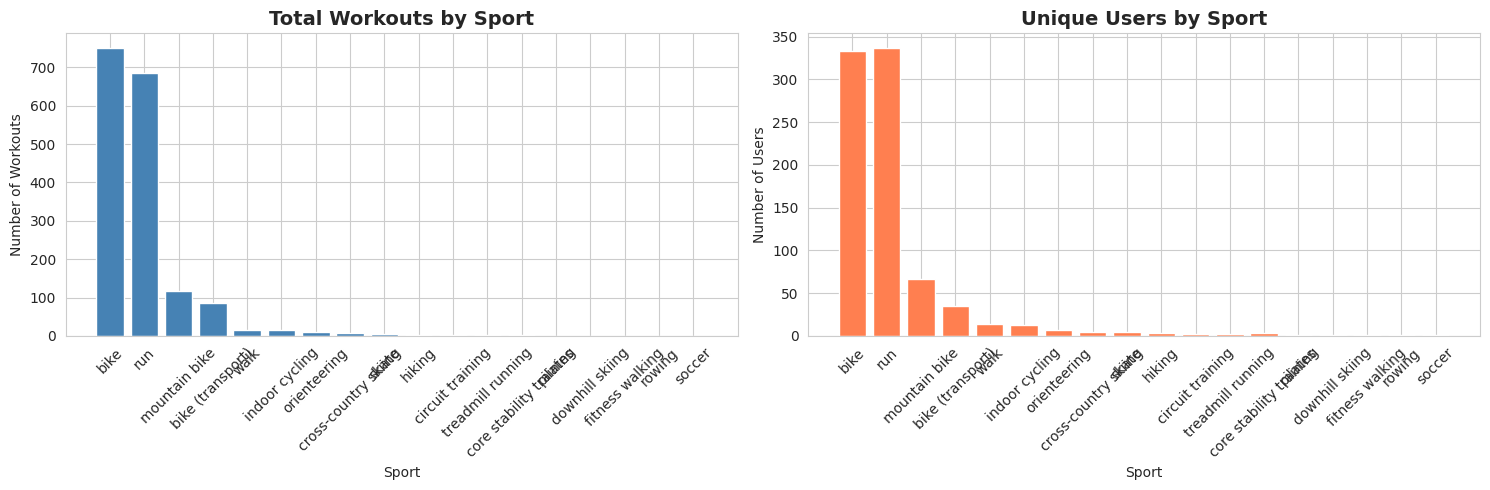

In [36]:
# VIZ 1: SPORT OVERVIEW (2 charts)
sport_stats_pd = sport_stats.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Workouts by sport
ax1.bar(sport_stats_pd['sport'], sport_stats_pd['total_workouts'], color='steelblue')
ax1.set_title('Total Workouts by Sport', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sport')
ax1.set_ylabel('Number of Workouts')
ax1.tick_params(axis='x', rotation=45)

# Unique users by sport
ax2.bar(sport_stats_pd['sport'], sport_stats_pd['unique_users'], color='coral')
ax2.set_title('Unique Users by Sport', fontsize=14, fontweight='bold')
ax2.set_xlabel('Sport')
ax2.set_ylabel('Number of Users')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Left Workouts by sport (Blue) | Right Unique users by sport ( Coral )

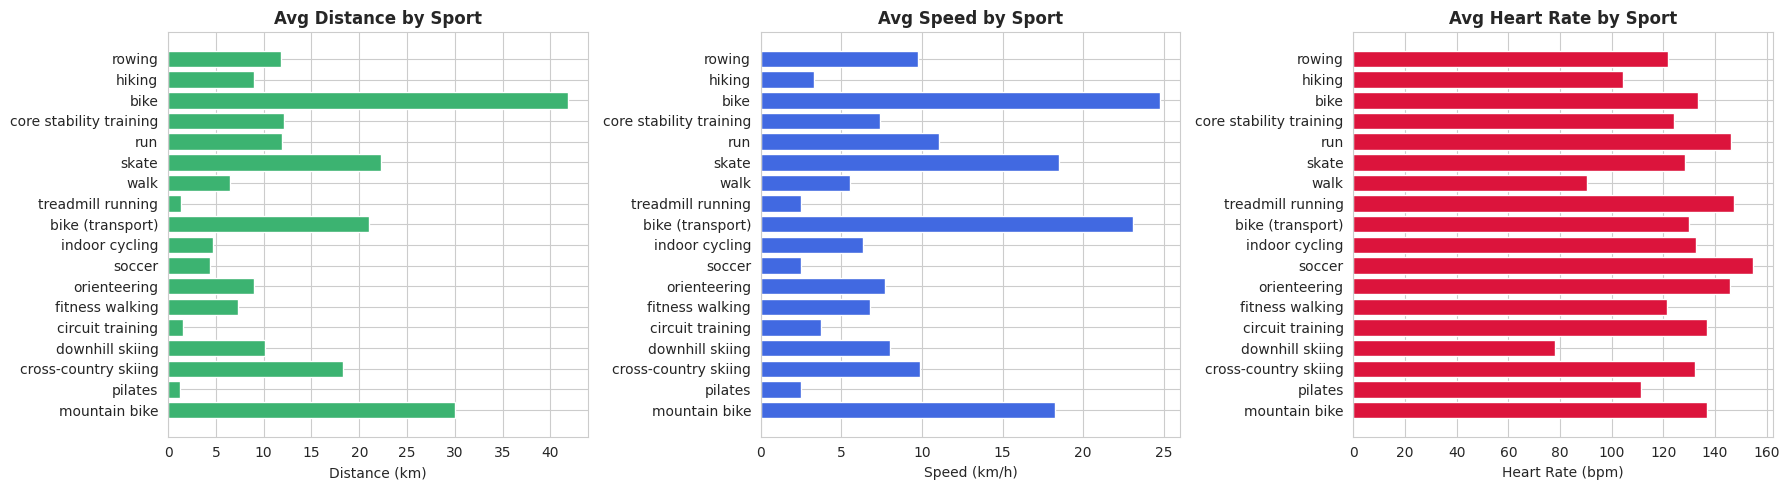

In [37]:

# VIZ 2: PERFORMANCE METRICS BY SPORT (3 key metrics)

sport_perf_pd = sport_performance.toPandas()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Average distance
ax1.barh(sport_perf_pd['sport'], sport_perf_pd['avg_distance_km'], color='mediumseagreen')
ax1.set_title('Avg Distance by Sport', fontsize=12, fontweight='bold')
ax1.set_xlabel('Distance (km)')

# Average speed
ax2.barh(sport_perf_pd['sport'], sport_perf_pd['avg_speed_kmh'], color='royalblue')
ax2.set_title('Avg Speed by Sport', fontsize=12, fontweight='bold')
ax2.set_xlabel('Speed (km/h)')

# Average heart rate
ax3.barh(sport_perf_pd['sport'], sport_perf_pd['avg_hr'], color='crimson')
ax3.set_title('Avg Heart Rate by Sport', fontsize=12, fontweight='bold')
ax3.set_xlabel('Heart Rate (bpm)')

plt.tight_layout()
plt.show()

Plot avg distance, speed, heart rate by sport

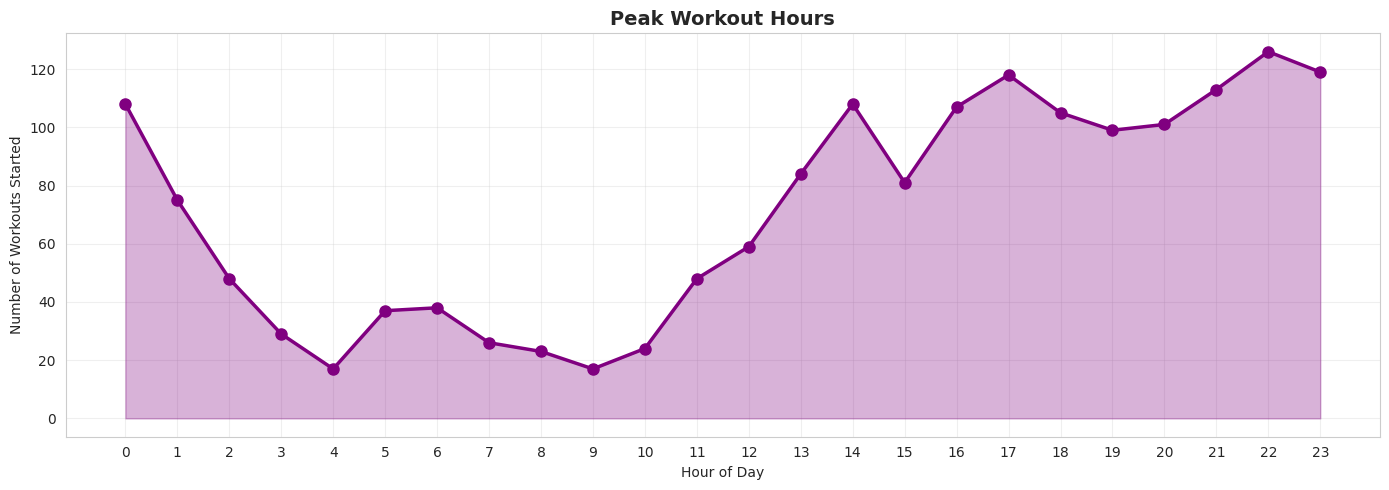

In [38]:

# VIZ 3: WORKOUT TIMING PATTERN

time_patterns_pd = time_patterns.toPandas()

plt.figure(figsize=(14, 5))
plt.plot(time_patterns_pd['hour_of_day'], time_patterns_pd['workouts_started'],
         marker='o', linewidth=2.5, markersize=8, color='purple')
plt.fill_between(time_patterns_pd['hour_of_day'], time_patterns_pd['workouts_started'],
                 alpha=0.3, color='purple')
plt.title('Peak Workout Hours', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Workouts Started')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

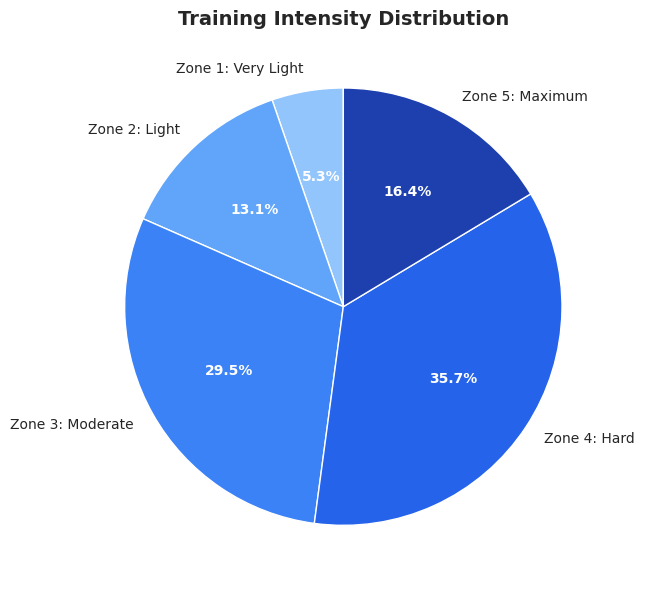

In [39]:

#  HEART RATE ZONES DISTRIBUTION

# Aggregate HR zones across all workouts
hr_zone_totals = hr_zones.groupBy("hr_zone").agg(
    count("*").alias("count")
).filter(col("hr_zone") != "Unknown").orderBy("hr_zone")

hr_zones_pd = hr_zone_totals.toPandas()

plt.figure(figsize=(10, 6))
colors = ['#93c5fd', '#60a5fa', '#3b82f6', '#2563eb', '#1e40af']
wedges, texts, autotexts = plt.pie(hr_zones_pd['count'],
                                     labels=hr_zones_pd['hr_zone'],
                                     autopct='%1.1f%%',
                                     colors=colors,
                                     startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
plt.title('Training Intensity Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Utilizing our hr_zone df for visuliazation where most are in hard and all the way lowest in very light

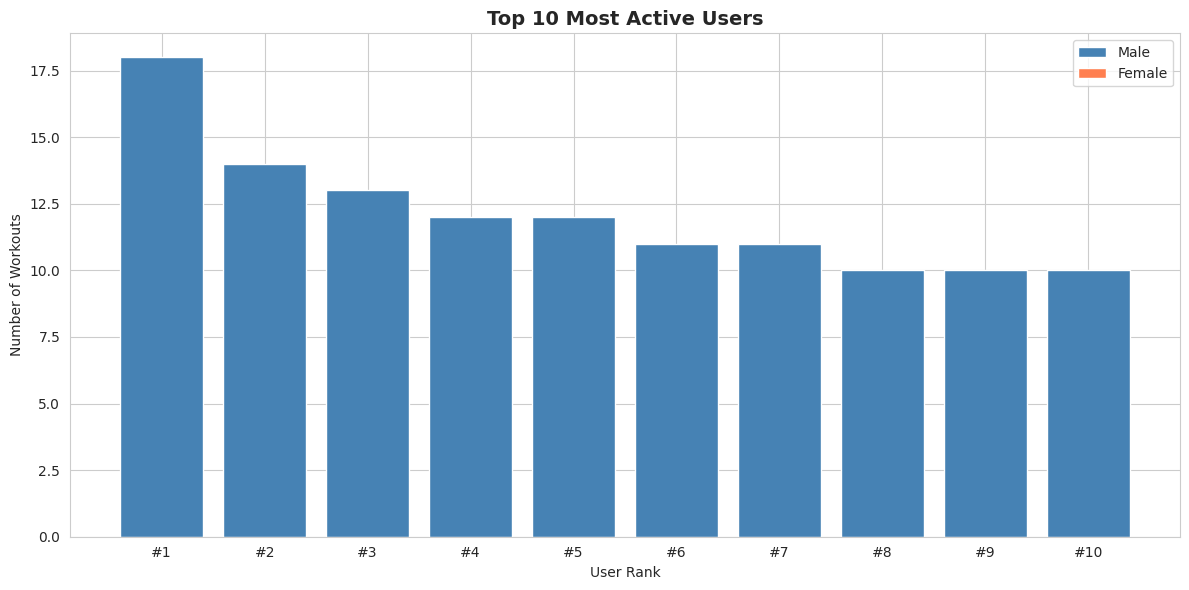

In [40]:

#  TOP 10 ACTIVE USERS

top_users_pd = top_users.toPandas()

plt.figure(figsize=(12, 6))
colors_list = ['steelblue' if g == 'male' else 'coral' if g == 'female' else 'gray'
               for g in top_users_pd['gender']]
bars = plt.bar(range(len(top_users_pd)), top_users_pd['workout_count'], color=colors_list)

plt.title('Top 10 Most Active Users', fontsize=14, fontweight='bold')
plt.xlabel('User Rank')
plt.ylabel('Number of Workouts')
plt.xticks(range(len(top_users_pd)), [f"#{i+1}" for i in range(len(top_users_pd))])

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Male'),
                   Patch(facecolor='coral', label='Female')]
plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()

Given dataset where most spread are male we see most active users all men with #1 at > 18

# Python Query Execution

10 queries in Python (via PySpark) to read and update database records

In [44]:
print("\n[QUERY 1] Read all running workouts")
running_workouts = spark.read \
    .format("mongodb") \
    .option("database", "fitrec_db") \
    .option("collection", "workouts") \
    .load() \
    .filter(col("sport") == "run")

print(f"Found {running_workouts.count()} running workouts")
running_workouts.select("workout_id", "user_id", "sport", "num_points").show(5)



[QUERY 1] Read all running workouts
Found 685 running workouts
+----------+-------+-----+----------+
|workout_id|user_id|sport|num_points|
+----------+-------+-----+----------+
| 260813100|3905196|  run|       500|
| 314869370|4007546|  run|       500|
| 279892973|4007546|  run|       500|
| 225359200|4007546|  run|       500|
| 113109144|4007546|  run|       500|
+----------+-------+-----+----------+
only showing top 5 rows



In [58]:
workouts_df.groupBy("sport").count().show()


+--------------------+-----+
|               sport|count|
+--------------------+-----+
|       mountain bike|  118|
|             pilates|    1|
|cross-country skiing|    7|
|              hiking|    3|
|     downhill skiing|    1|
|    circuit training|    3|
|     fitness walking|    1|
|        orienteering|   10|
|              soccer|    1|
|              rowing|    1|
|    bike (transport)|   85|
|      indoor cycling|   15|
|   treadmill running|    3|
|                walk|   16|
|               skate|    6|
|                 run|  685|
|core stability tr...|    3|
|                bike|  751|
+--------------------+-----+



In [59]:
workouts_df.groupBy("user_id").count().orderBy("count", ascending=False).show(10)
#identifies most active users.

+--------+-----+
| user_id|count|
+--------+-----+
| 2734298|   18|
| 4997910|   14|
| 1063624|   13|
|14066832|   12|
| 9051351|   12|
| 4446822|   11|
| 1520156|   11|
|  510054|   10|
| 7516129|   10|
|  171814|   10|
+--------+-----+
only showing top 10 rows



In [57]:
avg_hr = trackpoints_df.groupBy("workout_id").agg(
    F.avg("hr").alias("avg_hr")
)
avg_hr.show(5)
# returns avg_hr of user_id-worker_id

+----------+-------+
|workout_id| avg_hr|
+----------+-------+
|  26870785|135.494|
| 380089628| 153.29|
| 311878784|145.206|
| 311588215|160.316|
| 261637233|135.858|
+----------+-------+
only showing top 5 rows



In [60]:
workout_with_hr = workouts_df.join(avg_hr, "workout_id", "left")
workout_with_hr.select("workout_id", "sport", "avg_hr").show(10)


+----------+----------------+-------+
|workout_id|           sport| avg_hr|
+----------+----------------+-------+
| 225359200|             run|148.758|
| 399254445|            bike|136.406|
| 381331596|bike (transport)| 148.12|
| 565359568|            bike|136.782|
|  11503451|            bike| 107.85|
| 260813100|             run|156.624|
| 113109144|             run| 158.56|
| 279892973|             run|162.642|
| 497931952|            bike| 151.81|
| 314869370|             run|130.808|
+----------+----------------+-------+
only showing top 10 rows



adds physiological insight to workouts.


In [61]:
high_intensity = workout_with_hr.filter(F.col("avg_hr") > 145)
high_intensity.select("workout_id", "sport", "avg_hr").show(10)


+----------+-------------+-------+
|workout_id|        sport| avg_hr|
+----------+-------------+-------+
| 380089628|          run| 153.29|
| 311878784|         bike|145.206|
| 311588215|         bike|160.316|
| 469044127|         bike|151.572|
| 280284778|          run| 153.92|
| 295975873|          run|168.132|
| 330276136|         bike| 160.34|
| 305421472|          run| 147.04|
| 426786122|          run|147.812|
| 305088694|mountain bike|146.136|
+----------+-------------+-------+
only showing top 10 rows



In [47]:
#  Read workouts for a specific user
print("\n[QUERY 2] Read workouts for specific user (user_id = 430859|)")
user_workouts = spark.read \
    .format("mongodb") \
    .option("database", "fitrec_db") \
    .option("collection", "workouts") \
    .load() \
    .filter(col("user_id") == 430859)

print(f"User has {user_workouts.count()} workouts")
user_workouts.select("workout_id", "sport", "num_points").show()


[QUERY 2] Read workouts for specific user (user_id = 430859|)
User has 2 workouts
+----------+-----+----------+
|workout_id|sport|num_points|
+----------+-----+----------+
|  11503451| bike|       500|
|   5052313| bike|       500|
+----------+-----+----------+



In [48]:
trackpoints_df.show(3)

+--------------------+----+---+------------------+------------------+---+----------+----------+
|                 _id| alt| hr|               lat|               lon|seq| timestamp|workout_id|
+--------------------+----+---+------------------+------------------+---+----------+----------+
|69253753397f0125f...|30.6|106|60.183585081249475| 24.81770033016801|  0|1406665232| 381331596|
|69253753397f0125f...|30.6|110| 60.18354719504714|24.817550210282207|  1|1406665235| 381331596|
|69253753397f0125f...|30.8|113|  60.1835217140615|24.817379470914602|  2|1406665237| 381331596|
+--------------------+----+---+------------------+------------------+---+----------+----------+
only showing top 3 rows



In [50]:
# : Read trackpoints for a specific workout
print("\n[QUERY 3] Read trackpoints for workout_id =  381331596")
workout_trackpoints = spark.read \
    .format("mongodb") \
    .option("database", "fitrec_db") \
    .option("collection", "trackpoints") \
    .load() \
    .filter(col("workout_id") ==  381331596) \
    .orderBy("seq")

print(f"Found {workout_trackpoints.count()} trackpoints")
workout_trackpoints.select("seq", "lat", "lon", "hr", "alt").show(10)


[QUERY 3] Read trackpoints for workout_id =  381331596
Found 500 trackpoints
+---+------------------+------------------+---+----+
|seq|               lat|               lon| hr| alt|
+---+------------------+------------------+---+----+
|  0|60.183585081249475| 24.81770033016801|106|30.6|
|  1| 60.18354719504714|24.817550210282207|110|30.6|
|  2|  60.1835217140615|24.817379470914602|113|30.8|
|  3| 60.18352364189923| 24.81709599494934|116|30.8|
|  4| 60.18352163024247|24.816534323617816|122|30.8|
|  5| 60.18346128053963|  24.8162623308599|119|30.8|
|  6| 60.18338114954531| 24.81598732061684|118|30.8|
|  7|60.183330439031124|24.815907860174775|118|30.8|
|  8| 60.18304243683815| 24.81549915857613|118|30.8|
|  9| 60.18292131833732|24.815247869119048|119|30.8|
+---+------------------+------------------+---+----+
only showing top 10 rows



In [62]:
workout_with_hr.write.format("mongodb") \
    .mode("overwrite") \
    .option("database", "fitrec_db") \
    .option("collection", "workout_enriched") \
    .save()


In [63]:
spark_sport_metrics = workout_with_hr.groupBy("sport").agg(
    F.avg("avg_hr").alias("avg_sport_hr"),
    F.count("workout_id").alias("total_workouts")
)
spark_sport_metrics.show()


+--------------------+------------------+--------------+
|               sport|      avg_sport_hr|total_workouts|
+--------------------+------------------+--------------+
|       mountain bike|136.78208474576275|           118|
|             pilates|           111.226|             1|
|cross-country skiing|           132.378|             7|
|              hiking|104.29333333333334|             3|
|     downhill skiing|            78.154|             1|
|    circuit training|           136.732|             3|
|     fitness walking|           121.616|             1|
|        orienteering|          145.8524|            10|
|              soccer|           154.754|             1|
|              rowing|           121.774|             1|
|    bike (transport)| 129.9238588235294|            85|
|      indoor cycling|132.50573333333335|            15|
|   treadmill running|147.22733333333332|             3|
|                walk|            90.469|            16|
|               skate|128.25033

# Summary Report

## FitRec Workout Analysis Using MongoDB and PySpark — Summary Report Refer to docx report for full

This project explores how a non-relational database and a distributed processing framework can be used together to manage and analyse a semi-structured fitness dataset. The data originates from the FitRec collection (Ni, Muhlstein & McAuley, 2019), which contains detailed sensor readings and metadata describing real-world workouts. Because the original dataset is around 5GB—larger than what can be stored on the free tier of MongoDB Atlas (MongoDB Inc., n.d.)—a 1% sample was used, containing 1,710 workout sessions and roughly 855,000 trackpoints.

## Database Design and Setup

The dataset naturally separates into two components: workout-level metadata and large sequences of time-series measurements. To handle this efficiently in MongoDB, two collections were designed:

workouts – stores session metadata such as user ID, gender, sport, workout ID, and number of trackpoints.

trackpoints – stores each GPS/heart-rate reading as an individual document linked by workout_id.

A third collection, summary, was added to hold aggregated statistics such as sport distribution and total user counts. Indexes were applied to workout_id, user_id, and (workout_id, seq) to support fast lookups.

All 1,710 workouts and 855,000 trackpoints were inserted using batch inserts. The process produced a clean and consistent database suitable for querying.

## MongoDB Query Demonstration

A variety of queries were executed to verify both the structure of the database and its analytical usefulness.
Basic retrievals filtered workouts by gender and sport. Aggregation pipelines grouped workouts by sport, showing that bike and run were the most common activities. These results were stored in the summary collection, which was later updated with total user and workout counts.

More advanced queries used the $lookup operator to join workouts with their trackpoints. This allowed the calculation of average heart rate by sport, which revealed that activities such as running, orienteering, treadmill running, and soccer tended to produce the highest average heart-rate values. These queries demonstrated the usefulness of MongoDB’s aggregation framework for cross-collection analytics.

## PySpark Integration

Using the MongoDB Spark Connector (v10.x), both collections were loaded directly into Spark DataFrames. Spark correctly inferred the schema and handled the ~855k trackpoints efficiently.

Initial Spark analyses replicated earlier MongoDB queries, confirming data consistency. Workouts were grouped by sport and by user to identify activity patterns and the most active individuals.

To support deeper analysis, the trackpoints dataset was enriched with additional fields:
distance between GPS points, time differences, speed estimates, elevation changes, and human-readable timestamps. These features made it possible to compute workout-level summaries such as total distance, pace, and elevation gain.

Temporal exploration showed that evening workouts (5 PM–10 PM) were the most common. Heart-rate zone analysis revealed that many workouts included sustained high-intensity periods, especially in running and orienteering sessions.

## Python Query Execution via PySpark

A final set of queries demonstrated two-way interaction with MongoDB:

filtering workouts by sport (e.g., all running workouts)

identifying the most active users

computing per-workout average heart rate

retrieving all trackpoints for a specific workout

writing an enriched workout collection (workout_enriched) back to MongoDB

aggregating sport-level statistics directly in Spark

These operations confirmed that Spark is able to read, transform, and write MongoDB data reliably.

## Results and Discussion

Across both MongoDB and PySpark, the dataset showed consistent patterns. Cycling and running were the most frequent activities, with cycling covering longer distances and running producing higher heart-rate values. Evening sessions were common, and several workouts showed strong sustained intensity. Some sensor anomalies were present (e.g., GPS jumps, sudden speed spikes), but these did not significantly affect the general trends.

The system architecture—MongoDB for semi-structured storage and PySpark for scalable computation—proved effective for this dataset size and structure.

## Conclusion

This project demonstrated the complete workflow of loading, modelling, and analysing semi-structured sensor data using MongoDB and PySpark. The chosen schema was effective for storing large time-series measurements, and the integration with Spark enabled a wide range of analytical tasks, from sport-level summaries to heart-rate analysis and temporal behaviour patterns. Although the dataset contained minor sensor noise, it was sufficient to support meaningful insights. Future extensions could include additional cleaning stages, more visual dashboards, or expanded derived collections for higher-level analytics.